In [1]:
import nltk
from nltk.corpus import brown
#from nltk.tokenize import word_tokenize
import numpy as np
#import pandas as pd
import re
import copy
#import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, fbeta_score, ConfusionMatrixDisplay
import random #for shuffling list
from sklearn.model_selection import train_test_split
import tensorflow as tf
import gensim

nltk.download('punkt')
nltk.download('brown')
nltk.download('universal_tagset')
dataset = brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [ ]:
import gensim.downloader as api
import json
info = api.info()
#print(json.dumps(info, indent=4))
print(api.load('word2vec-google-news-300', return_path=True))

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', binary=True)

In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
words=[]
tags=[]
for sent_id in range(len(dataset)):
    for i in range(len(dataset[sent_id])):
        if len(dataset[sent_id]) ==1:
            words.append([dataset[sent_id][i][0],dataset[sent_id][i][0],dataset[sent_id][i][0]])
            tags.append(dataset[sent_id][i][1])
        
        elif i==0:
        
            words.append([dataset[sent_id][i][0],dataset[sent_id][i][0],dataset[sent_id][i+1][0]])
            tags.append(dataset[sent_id][i][1])
        
        elif i==len(dataset[sent_id])-1:
            words.append([dataset[sent_id][i-1][0],dataset[sent_id][i][0],dataset[sent_id][i][0]])
            tags.append(dataset[sent_id][i][1])
        else:
        
            words.append([dataset[sent_id][i-1][0],dataset[sent_id][i][0],dataset[sent_id][i+1][0]])
            tags.append(dataset[sent_id][i][1])
# del dataset

train_words,test_words, train_tags, test_tags=train_test_split(words,tags,test_size=0.2,train_size=0.8)

words_in_corpus = []
tags_in_corpus = []

for words_list in words:
    for item in words_list:
        words_in_corpus.append(item)
for tag in tags:
    tags_in_corpus.append(tag)

words_in_corpus = list(set(words_in_corpus))
tags_in_corpus = list(set(tags_in_corpus))

words_in_corpus.sort()
tags_in_corpus.sort()

print(len(words_in_corpus))
print(tags_in_corpus)

word_dictionary = dict()
tag_dictionary = dict()

for i in range ( len(tags_in_corpus) ):
    tag_dictionary[tags_in_corpus[i]] = i # 0 based indexing of IDs

for i in range ( len(words_in_corpus) ):
    word_dictionary[words_in_corpus[i]] = i # 0 based indexing of IDs

index_for_word_not_in_corpus = len(words_in_corpus)

56057
['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


In [ ]:
class dataset_pos_FFNN(Dataset):

    def __init__(self,words,tags,device):
        
        self.words=words
        self.tags=tags
        self.device=device

    def __len__(self):
        return len(self.words)
    

    def feature_matrix(self,word):

        try:
            f_mat=(np.concatenate((w2v_model[word[0]],w2v_model[word[1]],w2v_model[word[2]]), axis=0))

        except:

            x=np.random.normal(loc=0.0,scale=0.1,size=900)
            f_mat=x

        return f_mat
    def __getitem__(self, idx):
        # sentence=[]
        # tag_list=[]
        word=self.words[idx]
        tag=self.tags[idx]
        # tagged_sent=self.data[idx]
        # for item in tagged_sent:
            # sentence.append(item[0])
            # tag_list.append(item[1])
        feature=self.feature_matrix(word)
        return torch.Tensor(feature).to(self.device), int(tag_dictionary[tag])

In [ ]:
data_train=dataset_pos_FFNN(train_words,train_tags,"cuda")

In [ ]:
import torch.nn as nn
class FFNN(nn.Module):
    def __init__(self,in_dim,out_dim,device):
        super().__init__()
        self.in_dim=in_dim
        self.out_dim=out_dim
        self.device=device
        self.lin1=nn.Linear(in_dim,400).to(device)
        self.lin2=nn.Linear(400,50).to(device)
        self.lin3=nn.Linear(50,out_dim).to(device)
        self.relu=nn.ReLU().to(device)
        self.softmax=nn.Softmax().to(device)

    def forward(self,x):
        x=self.lin1(x)
        x=self.relu(x)
        x=self.lin2(x)
        x=self.relu(x)
        x=self.lin3(x)
        x=self.softmax(x)
        return x

In [ ]:
# import time
# device="cuda"
# dataloader = DataLoader(data_train, batch_size=100,
#                         shuffle=True, num_workers=0)
# model=FFNN(900,12,device)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# loss_fn=nn.CrossEntropyLoss()
# model.train()
# start=time.time()
# num_epochs=10
# for e in range(num_epochs):

#     for batch, (X, y) in enumerate(dataloader):
#         size = len(dataloader.dataset)
#         X, y = X.to(device), y.to(device)

#         # Compute prediction error
#         pred = model(X)
#         # print(pred.shape)
#         # print(y.shape)
#         loss = loss_fn(pred, y)

#         # Backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch % 500 == 0:
#             end=time.time()
#             loss, current = loss.item(), (batch + 1) * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
#             print("time: ", end-start)

loss: 2.484282  [  100/928953]
time:  2.8788068294525146
loss: 2.482563  [50100/928953]
time:  7.476841926574707
loss: 2.479968  [100100/928953]
time:  11.577924251556396
loss: 2.478201  [150100/928953]
time:  15.612863779067993
loss: 2.474979  [200100/928953]
time:  20.28514075279236
loss: 2.472354  [250100/928953]
time:  24.19670081138611
loss: 2.468724  [300100/928953]
time:  28.127317905426025
loss: 2.467615  [350100/928953]
time:  32.82713961601257
loss: 2.456418  [400100/928953]
time:  36.82357168197632
loss: 2.454973  [450100/928953]
time:  40.70963978767395
loss: 2.439890  [500100/928953]
time:  45.34734392166138
loss: 2.421545  [550100/928953]
time:  49.33854079246521
loss: 2.401737  [600100/928953]
time:  53.3344829082489


KeyboardInterrupt: ignored

In [ ]:
def train_func(data_train, data_test):
    import time
    device="cuda"
    dataloader = DataLoader(data_train, batch_size=100,
                            shuffle=True, num_workers=0)
    model=FFNN(900,12,device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    loss_fn=nn.CrossEntropyLoss()
    model.train()
    start=time.time()
    num_epochs=10
    for e in range(num_epochs):

        for batch, (X, y) in enumerate(dataloader):
            size = len(dataloader.dataset)
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            # print(pred.shape)
            # print(y.shape)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 500 == 0:
                end=time.time()
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                print("time: ", end-start)
    

    dataloader = DataLoader(data_test, batch_size=100,
                            shuffle=True, num_workers=0)
       
    a = torch.tensor([]).to(device)
    b = torch.tensor([]).to(device)

    for batch, (X, y) in enumerate(dataloader):
        size = len(dataloader.dataset)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # print(pred.shape)
        # print(y.shape)
        loss = loss_fn(pred, y)
        a = torch.cat((a, y))
        b = torch.cat((b, torch.argmax(pred, axis = 1)))

    return a, b

In [ ]:
def accuracy_per_fold(train_w, train_t, test_w, test_t):
    data_train = dataset_pos_FFNN(train_w,train_t,"cuda")
    data_test = dataset_pos_FFNN(test_w,test_t,"cuda")
    test_y,predictions = train_func(data_train, data_test)
    
    f1 = 0
    prec = 0
    recall = 0
    

    #for i in range( len(actual_tags) ):
    #    f1 += f1_score(actual_tags[i], predicted_tags[i], average='weighted')
    #    prec += precision_score(actual_tags[i], predicted_tags[i], average='weighted')
    #    recall += recall_score(actual_tags[i], predicted_tags[i], average='weighted')
    per_pos=[[] for i in range(12)]
    #per_pos_act=[[] for i in range(0,12)]
    for i in range(len(test_y)):
        per_pos[test_y[i].to(torch.int64).item()].append(predictions[i].to(torch.int64).item())
    print("my_fold------------------------")
    for i in range(len(per_pos)):
        print(i,"-----")
        true_tag=[i for j in range(len(per_pos[i]))]
        print("precision",precision_score(per_pos[i],true_tag, average='weighted'))
        print("recall",recall_score(per_pos[i],true_tag, average='weighted'))
        print("f1",f1_score(per_pos[i],true_tag, average='weighted'))
        print("f0.5",fbeta_score(per_pos[i],true_tag, average='weighted', beta = 0.5))
        print("f2",fbeta_score(per_pos[i],true_tag, average='weighted', beta = 2))
    print("overall for the batch:")
    precision=precision_score(test_y.to('cpu'),predictions.to('cpu'), average='weighted')
    recall=recall_score(test_y.to('cpu'),predictions.to('cpu'), average='weighted')
    f1=f1_score(test_y.to('cpu'),predictions.to('cpu'), average='weighted')
    f05 = fbeta_score(test_y.to('cpu'),predictions.to('cpu'), average='weighted', beta = 0.5)
    f2 = fbeta_score(test_y.to('cpu'),predictions.to('cpu'), average='weighted', beta = 2)
    print("precision",precision)
    print("recall",recall)
    print("f1",f1)
    print("f0.5",f05)
    print("f2",f2)

        
    return [precision, recall, f1, f05, f2]
    #return [f1/len(actual_tags), prec/len(actual_tags), recall/len(actual_tags)]

#total_acc_for_split1 = accuracy_per_fold(all_sentences[:57000], all_sentences[56000:56010])
#total_acc_for_split2 = accuracy_per_fold(all_sentences[:57000], all_sentences[57000:57010])

#print("\nTotal accuracy for the above split1: " + str(total_acc_for_split1))
#print("Total accuracy for the above split2: " + str(total_acc_for_split2) + "\n")
#exit(0)

def cross_validation_accuracy(words, tags):
    all_accuracies = []
    total_acc = [0, 0, 0, 0, 0]

    num_sentences = len(words)

    fold_size = int(num_sentences / 5)

    print(fold_size)

    fold1_train_w=words[:4*fold_size]
    fold1_test_w=words[4*fold_size:]
    fold2_train_w=words[:3*fold_size]+words[4*fold_size:]
    fold2_test_w=words[3*fold_size:4*fold_size]
    fold3_train_w=words[:2*fold_size]+words[3*fold_size:]
    fold3_test_w=words[2*fold_size:3*fold_size]
    fold4_train_w=words[:1*fold_size]+words[2*fold_size:]
    fold4_test_w=words[1*fold_size:2*fold_size]
    fold5_train_w=words[1*fold_size:]
    fold5_test_w=words[:1*fold_size]

    fold1_train_t=tags[:4*fold_size]
    fold1_test_t=tags[4*fold_size:]
    fold2_train_t=tags[:3*fold_size]+tags[4*fold_size:]
    fold2_test_t=tags[3*fold_size:4*fold_size]
    fold3_train_t=tags[:2*fold_size]+tags[3*fold_size:]
    fold3_test_t=tags[2*fold_size:3*fold_size]
    fold4_train_t=tags[:1*fold_size]+tags[2*fold_size:]
    fold4_test_t=tags[1*fold_size:2*fold_size]
    fold5_train_t=tags[1*fold_size:]
    fold5_test_t=tags[:1*fold_size]

    all_accuracies.append(accuracy_per_fold(fold1_train_w,fold1_train_t, fold1_test_w, fold1_test_t))
    print("Accuracy for fold ", "1", " is : ", str(all_accuracies[0]))
    total_acc[0] += all_accuracies[0][0]
    total_acc[1] += all_accuracies[0][1]
    total_acc[2] += all_accuracies[0][2]
    total_acc[3] += all_accuracies[0][3]
    total_acc[4] += all_accuracies[0][4]


    all_accuracies.append(accuracy_per_fold(fold2_train_w,fold2_train_t, fold2_test_w, fold2_test_t))
    print("Accuracy for fold ", "2", " is : ", str(all_accuracies[1]))
    total_acc[0] += all_accuracies[1][0]
    total_acc[1] += all_accuracies[1][1]
    total_acc[2] += all_accuracies[1][2]
    total_acc[3] += all_accuracies[1][3]
    total_acc[4] += all_accuracies[1][4]

    all_accuracies.append(accuracy_per_fold(fold3_train_w,fold3_train_t, fold3_test_w, fold3_test_t))
    print("Accuracy for fold ", "3", " is : ", str(all_accuracies[2]))
    total_acc[0] += all_accuracies[2][0]
    total_acc[1] += all_accuracies[2][1]
    total_acc[2] += all_accuracies[2][2]
    total_acc[3] += all_accuracies[2][3]
    total_acc[4] += all_accuracies[2][4]

    all_accuracies.append(accuracy_per_fold(fold4_train_w,fold4_train_t, fold4_test_w, fold4_test_t))
    print("Accuracy for fold ", "4", " is : ", str(all_accuracies[3]))
    total_acc[0] += all_accuracies[3][0]
    total_acc[1] += all_accuracies[3][1]
    total_acc[2] += all_accuracies[3][2]
    total_acc[3] += all_accuracies[3][3]
    total_acc[4] += all_accuracies[3][4]

    all_accuracies.append(accuracy_per_fold(fold5_train_w,fold5_train_t, fold5_test_w, fold5_test_t))
    print("Accuracy for fold ", "5", " is : ", str(all_accuracies[4]))
    total_acc[0] += all_accuracies[4][0]
    total_acc[1] += all_accuracies[4][1]
    total_acc[2] += all_accuracies[4][2]
    total_acc[3] += all_accuracies[4][3]
    total_acc[4] += all_accuracies[4][4]

    print("Cross validation accuracy is : ", str(np.array(total_acc) / 5))

In [ ]:
cross_validation_accuracy(train_words, train_tags)

185790
loss: 2.484286  [  100/743160]
time:  0.05959582328796387
loss: 2.482958  [50100/743160]
time:  7.258967876434326
loss: 2.479506  [100100/743160]
time:  11.210444688796997
loss: 2.474950  [150100/743160]
time:  15.147522449493408
loss: 2.475165  [200100/743160]
time:  19.854012966156006
loss: 2.470628  [250100/743160]
time:  23.83954644203186
loss: 2.466717  [300100/743160]
time:  27.97733449935913
loss: 2.461533  [350100/743160]
time:  32.43543481826782
loss: 2.455625  [400100/743160]
time:  36.52224254608154
loss: 2.437120  [450100/743160]
time:  40.87991452217102
loss: 2.445331  [500100/743160]
time:  45.2234308719635
loss: 2.390926  [550100/743160]
time:  49.17358112335205
loss: 2.391280  [600100/743160]
time:  53.63562893867493
loss: 2.350350  [650100/743160]
time:  57.8867301940918
loss: 2.356994  [700100/743160]
time:  61.84607219696045
loss: 2.340986  [  100/743160]
time:  65.86244821548462
loss: 2.318988  [50100/743160]
time:  70.08113837242126
loss: 2.457643  [100100/7

In [ ]:
train_w,test_w, train_t, test_t=train_test_split(words,tags,test_size=0.2,train_size=0.8)
data_train = dataset_pos_FFNN(train_w,train_t,"cuda")
data_test = dataset_pos_FFNN(test_w,test_t,"cuda")
a, b = train_func(data_train, data_test)
a = a.cpu().numpy()
b = b.cpu().numpy()
cm = confusion_matrix(a, b)

loss: 2.482372  [  100/928953]
time:  0.49555492401123047
loss: 2.479100  [50100/928953]
time:  4.717587232589722
loss: 2.474238  [100100/928953]
time:  9.11570143699646
loss: 2.476537  [150100/928953]
time:  13.69041919708252
loss: 2.474215  [200100/928953]
time:  17.72758460044861
loss: 2.465506  [250100/928953]
time:  23.692746877670288
loss: 2.458633  [300100/928953]
time:  30.937087059020996
loss: 2.457147  [350100/928953]
time:  38.3901731967926
loss: 2.457438  [400100/928953]
time:  42.44611358642578
loss: 2.436890  [450100/928953]
time:  47.37596344947815
loss: 2.411918  [500100/928953]
time:  54.42568397521973
loss: 2.381072  [550100/928953]
time:  61.624125957489014
loss: 2.410912  [600100/928953]
time:  65.70071029663086
loss: 2.391088  [650100/928953]
time:  69.7889552116394
loss: 2.406060  [700100/928953]
time:  74.724374294281
loss: 2.408462  [750100/928953]
time:  78.83386635780334
loss: 2.390411  [800100/928953]
time:  83.45919728279114
loss: 2.381098  [850100/928953]
t

NameError: ignored

ValueError: ignored

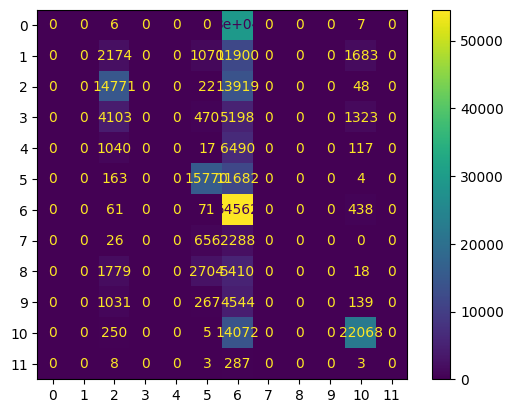

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show() 

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, fbeta_score, ConfusionMatrixDisplay